In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import urllib.request
import os.path
from scipy.signal import find_peaks

**Download csv data if not already downloaded.**

In [2]:
filename = "weekly_in_situ_co2_mlo.csv"
data_url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv"
if (os.path.isfile(filename)):
    print("File is already downloaded.")
else:
    urllib.request.urlretrieve(data_url, filename)
    print("File downloaded")

File is already downloaded.


**Load csv file and remove entries with missing values**

In [3]:
raw_data = pd.read_csv(filename, skiprows=44, header=0, names= ["date","CO2_ppm"])
raw_data[raw_data.isnull().any(axis=1)]
data = raw_data.dropna().copy()

**Sort data if it is not sorted by date**

In [4]:
data["date"] = pd.to_datetime(data["date"],format="%Y-%m-%d")
if (data["date"].is_monotonic):
    sorted_data = data
    print("Data is already sorted by date")
else:
    sorted_data = data.sort_values("date",axis=1)
    print("Data sorted by date")


Data is already sorted by date


**Plot data and adjust quadratic polynomial. A projection to 2025 is done with the polynomial fit**

We can fit a quadratic polynom to the data as follows:
CO2[ppm]= 1.01e-07*d^2 +2.03e-03*d +3.15e+02
where 'd' is the days that have passed since 1958-04-05 00:00:00


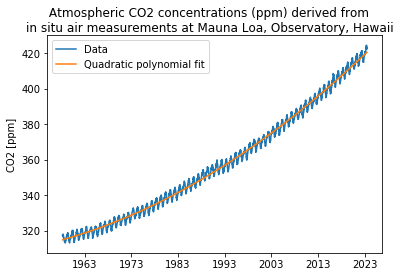

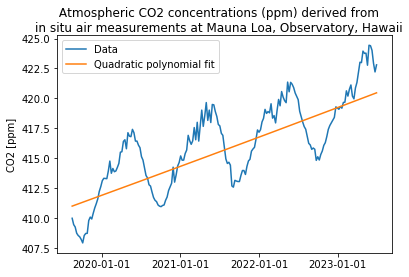

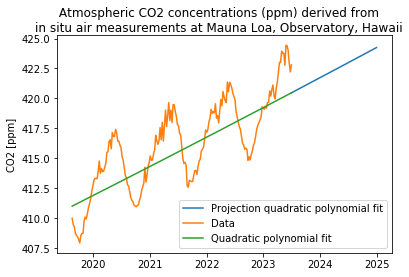

In [5]:
data["timedelta"] = data["date"]-data["date"][0]
slow_fit = np.polyfit(data['timedelta'].dt.days,data['CO2_ppm'],deg=2)
data["slow_fit"] = slow_fit[2] + data['timedelta'].dt.days.multiply(slow_fit[1]) + data['timedelta'].dt.days.pow(2).multiply(slow_fit[0])
print("We can fit a quadratic polynom to the data as follows:")
print("CO2[ppm]= {0:.2e}*d^2 +{1:.2e}*d +{2:.2e}".format(slow_fit[0],slow_fit[1],slow_fit[2]))
print("where 'd' is the days that have passed since {}".format(data["date"][0]))

lastpoints = 200

fig1, ax1 = plt.subplots()
ax1.plot(data["date"],data["CO2_ppm"],label="Data")
ax1.set_ylabel("CO2 [ppm]")
fig1.suptitle(" Atmospheric CO2 concentrations (ppm) derived from \nin situ air measurements at Mauna Loa, Observatory, Hawaii")
ax1.plot(data["date"],data["slow_fit"],label="Quadratic polynomial fit")
ax1.legend();

fig2, ax2 = plt.subplots()
ax2.plot(data["date"][-lastpoints:],data["CO2_ppm"][-lastpoints:],label="Data")
ax2.set_ylabel("CO2 [ppm]")
ax2.xaxis.set_major_locator(mdates.YearLocator(1,month=1, day=1))
ax2.xaxis.set_major_formatter(
    mdates.AutoDateFormatter(ax2.xaxis.get_major_locator()))
fig2.suptitle(" Atmospheric CO2 concentrations (ppm) derived from \nin situ air measurements at Mauna Loa, Observatory, Hawaii")
ax2.plot(data["date"][-lastpoints:],data["slow_fit"][-lastpoints:],label="Quadratic polynomial fit")
ax2.legend();

fig3, ax3 = plt.subplots()
daysto2025 = pd.to_datetime("01-01-2025",format="%d-%m-%Y")-data["date"][0]
t_proj = np.array([*range(data['timedelta'].dt.days.iloc[-1],daysto2025.days)])
data_proj = slow_fit[2] + np.multiply(t_proj,slow_fit[1]) + slow_fit[0]*np.multiply(t_proj,t_proj)
ax3.plot(data["date"][0]+pd.to_timedelta(t_proj, unit='d'),data_proj,label="Projection quadratic polynomial fit")
ax3.plot(data["date"][-lastpoints:],data["CO2_ppm"][-lastpoints:],label="Data")
ax3.plot(data["date"][-lastpoints:],data["slow_fit"][-lastpoints:],label="Quadratic polynomial fit")
ax3.set_ylabel("CO2 [ppm]")
fig3.suptitle(" Atmospheric CO2 concentrations (ppm) derived from \nin situ air measurements at Mauna Loa, Observatory, Hawaii")
ax3.legend();








**Once we hace the slow contribution model, we can use it as a baseline to properly characterize the periodic oscillation**
**We can see that the periodic oscillation frequency is around a year. For that we analyze the peaks in the signal, and the frequency of the peaks at a maximum value**


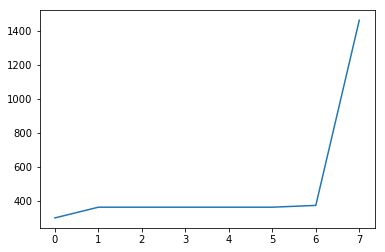

In [6]:
data["slow_fit_substracted"] = data["CO2_ppm"] - data["slow_fit"]

freq_med = []
for prom in range(1,9):
    high_peaks, _ = find_peaks(data["slow_fit_substracted"], prominence=prom)
    low_peaks, _ = find_peaks(-data["slow_fit_substracted"], prominence=prom)
    hp_interval = [(p1-p0).days for p0,p1 in zip(data["date"][high_peaks][:-1],data["date"][high_peaks][1:])]
    freq_med.append(np.median(hp_interval))

fig4, ax4 = plt.subplots()
ax4.plot(freq_med)

**Around a prominence equal to 3, we see the frequency of the periodicity , and the peaks are properly represented as shown in the next plot**

The frequency for periodic oscillations is 364.0 days


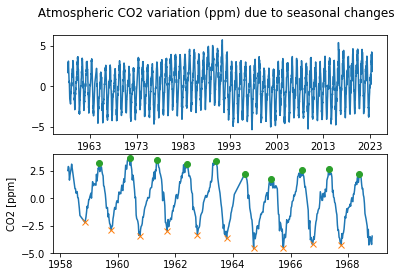

In [7]:
high_peaks, _ = find_peaks(data["slow_fit_substracted"], prominence=3)
low_peaks, _ = find_peaks(-data["slow_fit_substracted"], prominence=3)  
hp_interval = [(p1-p0).days for p0,p1 in zip(data["date"][high_peaks][:-1],data["date"][high_peaks][1:])]
lp_interval = [(p1-p0).days for p0,p1 in zip(data["date"][low_peaks][:-1],data["date"][low_peaks][1:])]
print("The frequency for periodic oscillations is {} days".format(np.mean([np.median(hp_interval),np.median(lp_interval)])))
fig5, (ax5a,ax5b) = plt.subplots(2,1)
ax5a.plot(data["date"],data["slow_fit_substracted"],label="Data with baseline correction")
ax5b.plot(data["date"][:500],data["slow_fit_substracted"][:500],label="Data with baseline correction")
ax5b.set_ylabel("CO2 [ppm]")
fig5.suptitle(" Atmospheric CO2 variation (ppm) due to seasonal changes")
ax5b.plot(data["date"][low_peaks][:10],data["slow_fit_substracted"][low_peaks][:10],"x")
ax5b.plot(data["date"][high_peaks][:10],data["slow_fit_substracted"][high_peaks][:10],"o")

**As seen, after substracting the slow contribution, there slow growth dissapeared but with an apparent remaining variation.
First, we check if there is a change in the frequency of the oscillations, for that, we find the high and low peaks and
** we plot the difference in days from one high/low peak to another high/low peak**

There is no apparent change in the frequency at which periodic oscillations occur from 1958-04-05 00:00:00 to 2023-07-01 00:00:00


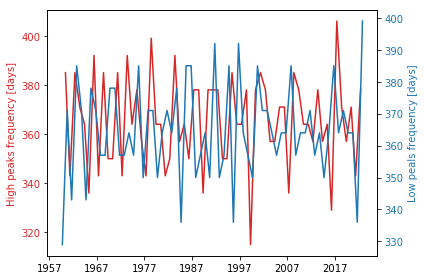

In [8]:
fig6,ax6a = plt.subplots()

high_peaks_df = pd.DataFrame(data={'high_peak':np.ones(len(hp_interval),dtype=bool),'date':data["date"][high_peaks][1:],'freq':hp_interval, 'CO2_ppm':data["CO2_ppm"][high_peaks][1:]})
color = 'tab:red'
ax6a.set_ylabel('High peaks frequency [days]', color=color)
ax6a.plot(high_peaks_df["date"], high_peaks_df["freq"], color=color)
ax6a.tick_params(axis='y', labelcolor=color)
ax6b = ax6a.twinx()  # instantiate a second axes that shares the same x-axis

low_peaks_df = pd.DataFrame(data={'high_peak':np.zeros(len(lp_interval),dtype=bool),'date':data["date"][low_peaks][1:],'freq':lp_interval, 'CO2_ppm':data["CO2_ppm"][low_peaks][1:]})
color = 'tab:blue'
ax6b.set_ylabel('Low peals frequency [days]', color=color)  # we already handled the x-label with ax1
ax6b.plot(low_peaks_df["date"], low_peaks_df["freq"], color=color)
ax6b.tick_params(axis='y', labelcolor=color)

fig6.tight_layout()  # otherwise the right y-label is slightly clipped
print("There is no apparent change in the frequency at which periodic oscillations occur from {} to {}".format(data["date"][0],data["date"].iloc[-1]))

**To find the amplitude, the CO2 concentration difference between consecutive high and low peaks needs to be calculated.
First, the high and low peaks are saved in a dataframe to check that they are sorted one next to the other.**

In [9]:
all_peaks_df = pd.concat([high_peaks_df,low_peaks_df])
all_peaks_sorted = all_peaks_df.sort_values(by=["date"])
idx = [idx1 != idx0 for idx1, idx0 in zip(all_peaks_sorted["high_peak"][1:],all_peaks_sorted["high_peak"][:-1])]
if any(idx):
    print("All peaks were correctly sorted")
else:
    print("Peaks were not correctly sorted")

All peaks were correctly sorted


**Finally, we calculate the amplitude between consecutive high and low peaks, and we plot this 
amplitude to see if it has changed with time**

Text(0,0.5,'CO2 concentration [ppm]')

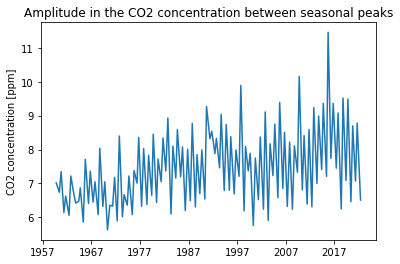

In [10]:
amplitude = [abs(pk1 - pk0) for pk1, pk0 in zip(all_peaks_sorted["CO2_ppm"][1:],all_peaks_sorted["CO2_ppm"][:-1])]
plt.plot(all_peaks_sorted["date"][:-1],amplitude)
plt.title("Amplitude in the CO2 concentration between seasonal peaks")
plt.ylabel("CO2 concentration [ppm]")

**As it can be seen on the graph, the amplitude is slowly changing overtime, a lineal model is then adjusted to corroborate**

In [11]:
amp_days = all_peaks_sorted["date"][:-1]-all_peaks_sorted["date"].iloc[0]
amp_fit = np.polyfit(amp_days.dt.days,amplitude,deg=1)

array([6.67344215e-05, 6.69351325e+00])

The amplitude between seasonal CO2 concentration oscillations is growing at a pace of 0.024 ppm of CO2 per year,
with a seasonal variation (peak to peak) of around 6.694 ppm in 1958-04-05 00:00:00 to  8.220 ppm in 2023-07-01 00:00:00 


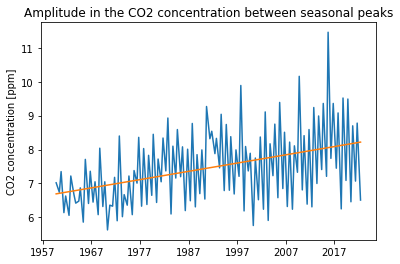

In [20]:
plt.plot(all_peaks_sorted["date"][:-1],amplitude)
plt.title("Amplitude in the CO2 concentration between seasonal peaks")
plt.ylabel("CO2 concentration [ppm]")
amp_poly = amp_days.dt.days.multiply(amp_fit[0])+amp_fit[1]
plt.plot(all_peaks_sorted["date"][:-1],amp_poly)
print("The amplitude between seasonal CO2 concentration oscillations is growing at a pace of {0:.3f} ppm of CO2 per year,".format(365*amp_fit[0]))
print("with a seasonal variation (peak to peak) of around {0:.3f} ppm in {1} to  {2:.3f} ppm in {3} ".format(amp_poly.iloc[0],data["date"][0],amp_poly.iloc[-1],data["date"].iloc[-1]))